# Libraries

In [2]:
import numpy as np
import os, json, cv2, random
import skimage.io as io
import pylab
import sys
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image
import shutil

In [3]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Data preparation

## Register

In [8]:
dataset_dir = "dataset/"
train_dir = "images/train/"
val_dir = "images/val/"
test_dir = "images/test/"

In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("bcd_train", {}, os.path.join(dataset_dir,train_dir,"train.json"), os.path.join(dataset_dir,train_dir))
register_coco_instances("bcd_val", {}, os.path.join(dataset_dir,val_dir,"val.json"), os.path.join(dataset_dir,val_dir))
register_coco_instances("bcd_test", {}, os.path.join(dataset_dir,test_dir,"test.json"), os.path.join(dataset_dir,test_dir))

## Visualization

In [10]:
dataset_dicts = DatasetCatalog.get("bcd_train")
metadata_dicts = MetadataCatalog.get("bcd_train")

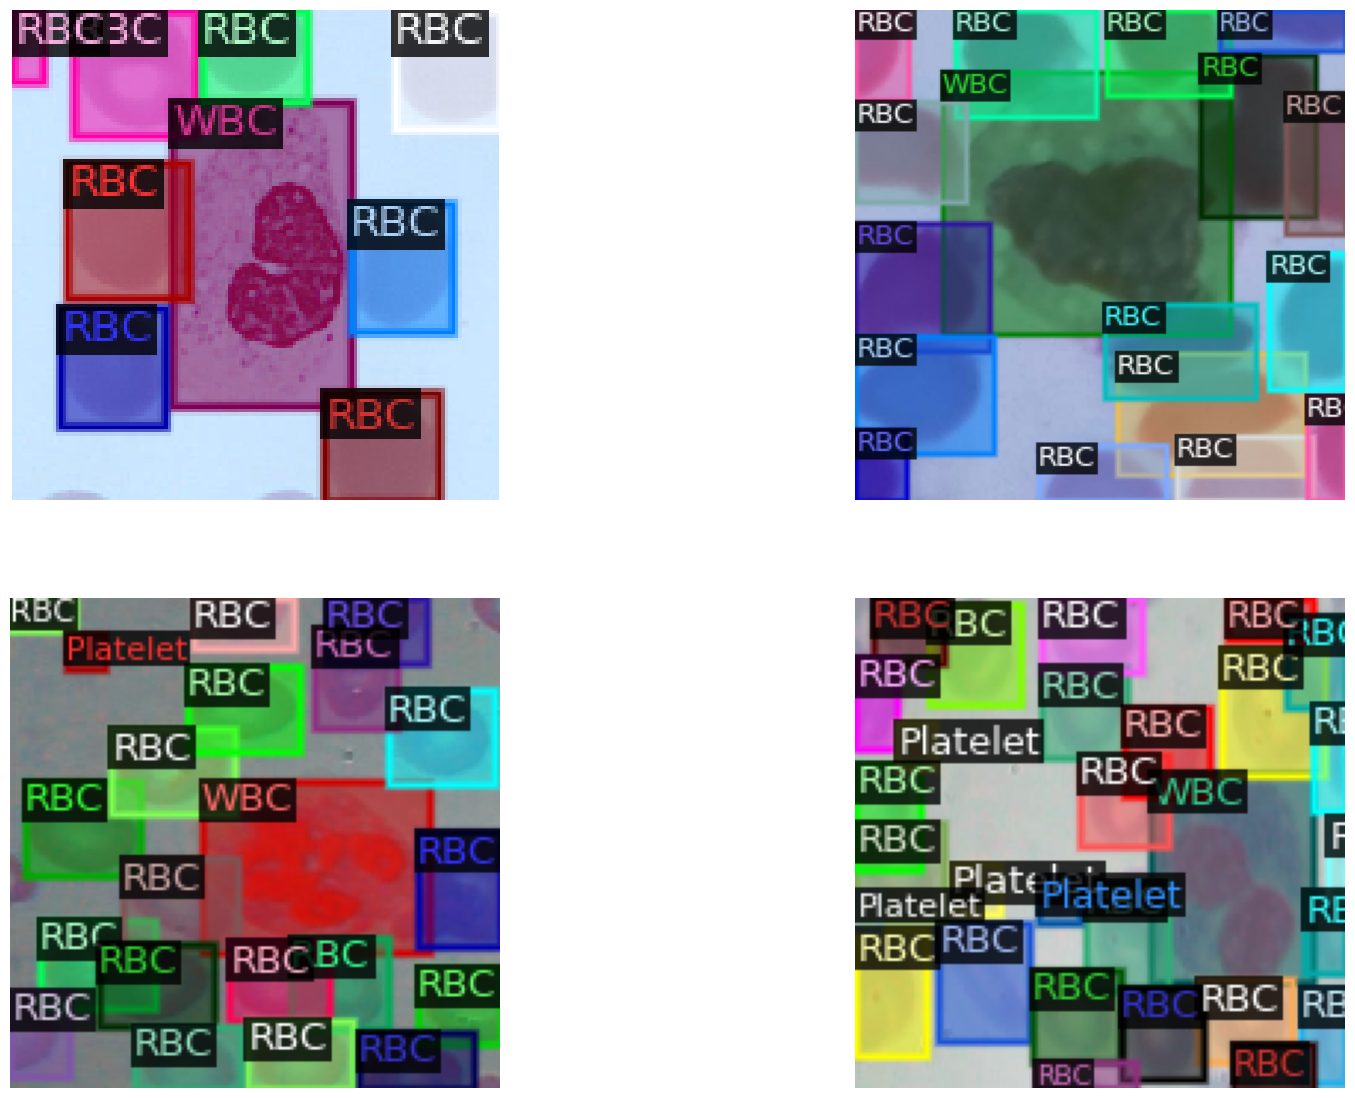

In [11]:
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(dataset_dicts, 4):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])
    

## Augmentation

In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((640,640)),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Training model

In [13]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.MODEL.DEVICE = "cpu"

cfg.DATASETS.TRAIN = ("bcd_train",)
cfg.DATASETS.TEST = ("bcd_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3500 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
#trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/20 20:50:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[04/20 20:50:08 d2.engine.train_loop]: Starting training from iteration 0


d:\Quan\Code\Python\BCD\venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/20 21:12:46 d2.utils.events]:  eta: 2 days, 11:51:28  iter: 19  total_loss: 3.172  loss_cls: 1.754  loss_box_reg: 0.9251  loss_rpn_cls: 0.4096  loss_rpn_loc: 0.09786    time: 62.1912  last_time: 65.0061  data_time: 1.1822  last_data_time: 0.0471   lr: 4.9953e-06  
[04/20 21:32:54 d2.utils.events]:  eta: 2 days, 9:31:31  iter: 39  total_loss: 2.976  loss_cls: 1.644  loss_box_reg: 0.9182  loss_rpn_cls: 0.3171  loss_rpn_loc: 0.09164    time: 61.2131  last_time: 69.1176  data_time: 0.0594  last_data_time: 0.1209   lr: 9.9903e-06  
[04/20 21:55:25 d2.utils.events]:  eta: 2 days, 9:37:55  iter: 59  total_loss: 2.598  loss_cls: 1.451  loss_box_reg: 0.9078  loss_rpn_cls: 0.1485  loss_rpn_loc: 0.08575    time: 63.4045  last_time: 64.4168  data_time: 0.0773  last_data_time: 0.0388   lr: 1.4985e-05  
[04/20 21:56:40 d2.engine.hooks]: Overall training speed: 59 iterations in 1:02:31 (63.5910 s / it)
[04/20 21:56:40 d2.engine.hooks]: Total training time: 1:02:33 (0:00:01 on hooks)
[04/20 21:56:

KeyboardInterrupt: 

In [15]:
import json
from collections import Counter

# Paths to your COCO annotation JSON files
json_paths = {
    "train": "dataset/images/train/train.json",
    "val": "dataset/images/val/val.json",
    "test": "dataset/images/test/test.json"
}

def check_duplicate_annotation_ids(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    annotation_ids = [ann['id'] for ann in data.get('annotations', [])]
    duplicates = [item for item, count in Counter(annotation_ids).items() if count > 1]
    return duplicates

# Run check
for split, path in json_paths.items():
    duplicates = check_duplicate_annotation_ids(path)
    if duplicates:
        print(f"[{split.upper()}] Duplicate annotation IDs found: {duplicates[:10]}{'...' if len(duplicates) > 10 else ''}")
    else:
        print(f"[{split.upper()}] No duplicate annotation IDs found.")


[TRAIN] No duplicate annotation IDs found.
[VAL] Duplicate annotation IDs found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...
[TEST] Duplicate annotation IDs found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...
